# ДЗ №2

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def split_data_b( data, split_date ):
    return data.loc[data.index <= split_date].copy(), data.loc[data.index >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Обозначения:
- p - глубина истории, сколько измерений назад учитываем в моделях
- h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

**1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти".**

**2. Оцените ошибку модели из п.1.**

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [3]:
d_data = data.resample('D').mean()
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)

In [4]:
df = pd.DataFrame(data = data_exp_1, index = d_data.index)

# история - глубина 3 измерения
for i in range(1,4):
    df[f't{i}'] = 0
    df.iloc[i:, i] = df.iloc[:-i, 0].values

# сглаживания - 3 вида
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)

# разности - 1-й порядок
df['diff1'] = df.iloc[:, 0].diff()
df.fillna(0, inplace=True)

df.head(5)

,0,t1,t2,t3,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,-55.693138


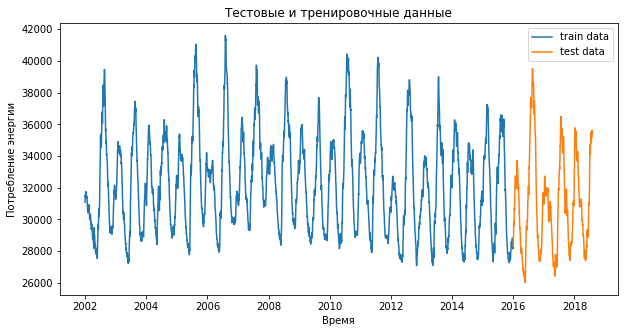

In [10]:
SPLIT_DATE = '2016-01-01'
train, test = split_data_b(df, SPLIT_DATE)
plt.figure( figsize=( 10, 5 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index, train[df.columns[0]], label='train data' )
plt.plot(test.index, test[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [6]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [7]:
def showResult(h = 1):
    X_train = train.iloc[:-h,:]
    y_train = train[df.columns[0]].values[h:]
    X_test = test.iloc[:-h,:]
    y_test = test[df.columns[0]].values[h:]
    
    model_gb.fit( X_train, y_train ) 
    X_test_pred = model_gb.predict(X_test)
    
    plt.figure( figsize=( 10, 4 ))
    plt.xlabel('Время')
    plt.ylabel('Потребление энергии')
    plt.plot(test.index[h:],X_test_pred, label='predict GB data' )
    plt.plot(test.index[h:],y_test, label='test data')
    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)
    print(f'h={h} - ошибка градиентного бустинга = {er_g} %')

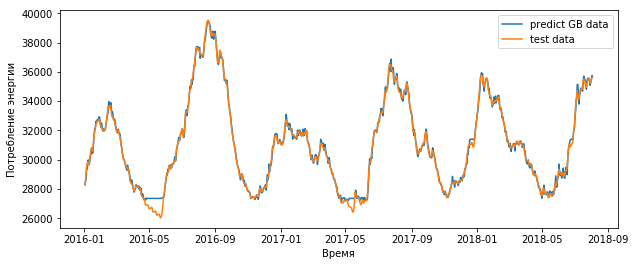

h=1 - ошибка градиентного бустинга = 0.5648298278275464 %


In [8]:
showResult(1)

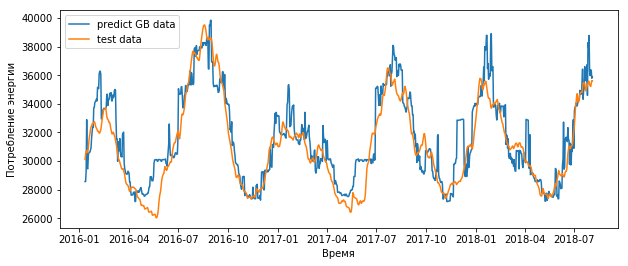

h=10 - ошибка градиентного бустинга = 3.659996728668402 %


In [9]:
showResult(10)

**3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.**

> Очевидно что ошибка модели будет выше при увеличении глубины прогноза

**4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):**

    а) Изменение температуры за окном :).

>    с сезоном (времена года), с циклом (вечером/днем), без тренда (если конечно не учитывать глобальное потепление)

> предполагаю что если убрать сезонность и цикл ряд можно считать стационарным так как в среднем погода меняется незначительно

    б) Количество денег, которые тратят покупатели в интернет магазине.

>  с сезоном (перед праздниками больше), с трендом (интернет торговля процветает с каждым годом), без четко выраженного цикла

> не стационарный

    в) Вес растущего котенка.

> с трендом (глобально вес всегда растет потому что котенок растет), без сезона (вес не зависит от времени), без цикла (даже если он меньше поел и немного похудел нельзя сказать что это строго связано)

> не стационарный

    г) Прирост объема деревьев в лесу от времени

> если не брать во внимание что здесь очень много факторов которые могут повлиять на количество деревьев (начиная от пожаров заканчивая плановый посадкой новых деревьев) - можно считать что данный ряд имеет тренд (глобально количество деревьев всегда приростает со временем), думаю что без сезона и без цикла

> не стационарный